# Firm Entry and Exit - Week 4 - OSE Lab
## Thomas Pellet
### 07/2019

## Question 1: Define a Recursive Equilibrium

As in Khan & Thomas (2009), it is possible to define a recursive equilibrium for the model. This equilibrium consists of four conditions:
* Firms maximize their value given households preferences (Stochastic discount factor pricing contingent claims). In other words, we have that
<p align="center">
$\frac{1}{1+r} = \beta \frac{C_{t+1}}{C_t} $
</p>
* The free entry condition holds, so that incumbent firms are at least indifferent between entering the market with zero capital or staying out. 
<p align="center">
$c_{e} \leq \int v(\varepsilon, 0) \nu(d \varepsilon)$
</p>
* The labor and goods market clears: 
<p align="center">
$N(z, g)=\int n(\varepsilon, k ; z, g) g(\varepsilon, k) d \varepsilon d k$
</p>
<p align="center">
$C(z, g)=\int y(\varepsilon, k ; z, g)  - i(\varepsilon, k ; z, g) d \varepsilon d k$
</p>
* The distribution of active firms $g^*(\epsilon,k)$ is stationary

## Question 2: Compute Representative Agent Steady State

In [95]:
from scipy.optimize import fsolve
import numpy as np

θ, ν, δ, β, ϕ, Nrep, Nϵ, cf = .21, .64, .1, 0.96, .5, .6, 10, 0.01
#Tauchen parameters
ρ,μ,σ =.9,0,.02


def steady_state_eqns(x, *args):
    Nrep, δ, β, θ, ν = args
    w = x[0]
    c = x[1]
    k = x[2]
    r = 1/β - (1 - δ)
    ret = np.zeros(3)
    ret[0] = r - θ* Nrep**ν * k**(θ-1)
    ret[1] = w - ν* Nrep**(ν-1) * k**(θ)
    ret[2] = c + k*δ - k**θ * Nrep**ν
    return ret

In [96]:
params = Nrep, δ, β, θ, ν
ss_vals = fsolve(steady_state_eqns, [.1,.3,.1], args=params) 
print("Steady State Wage: {}".format(ss_vals[0]))
print("Steady State Consumption: {}".format(ss_vals[1]))
print("Steady State Capital: {}".format(ss_vals[2]))
wrep = ss_vals[0]
Krep = ss_vals[2]

Steady State Wage: 0.7829715643836618
Steady State Consumption: 0.6252258227354607
Steady State Capital: 1.088100188742222


## Question 3: Solve for Incumbent Firms' Decision Rules

In [97]:
# Production function
def prod(ϵ, k, n):
    if k > 0:
        return np.exp(ϵ) * k**θ * n**ν
    else:
        return -50000000


# Wages
w_f     = lambda ϵ, k, n: ν * np.exp(ϵ) * k**θ * n**(ν-1)

# Labor supply
n_f       = lambda ϵ, k, w: (w / (ν * np.exp(ϵ) * k**θ ))**(1/(ν-1))

# Interest rate
r_f     = lambda ϵ, k, n: θ * np.exp(ϵ) * k**(θ-1) * n**ν

# Profits
Π     = lambda y, kp, k, n, w: y - w*n - (kp - (1 - δ)*k) - 0.5*ϕ * \
        (kp/k - (1-δ))**2*k



# Utility function
def Uprime(c):
    if c > 0:
        return 1/c
    else:
        return 50000000




In [105]:
import numpy as np
from scipy.optimize import minimize
from scipy import interpolate
from matplotlib import pyplot as plt
import tauchen

sizeK = 20
tol, epsi, maxiter =1e-6,1, 1000
Nϵ = 5
### State space K
Kmin=0.1
Kmax=4
Kgrid=np.linspace(Kmin,Kmax,sizeK)

### State space epsilon, from Tauchen
[A, P] = tauchen.approx_markov(ρ, σ, m=2, n=Nϵ)  #b is the constant in the AR1 and m is the standard deviation span #b is the constant in the AR1 and m is the standard deviation span


# ##interpolation function that returns function handle given interp type
# def interpolate(k_grid, policy, method="pw-linear", ndegree=None, A=None ):
#     if method == "pw-linear":
#         t = interpol.interp1d(k_grid, policy, kind='linear',fill_value="extrapolate")
            
#     elif method == "chebyshev":
#         ###Get chebyshev coefficients 
#         coeff = chebyshev.chebfit(k_grid, policy, ndegree)
#         t = lambda x: chebyshev.chebval(x, coeff)

#     elif method == "cubic-spline":
#         t = interpol.interp1d(k_grid, policy, kind='cubic',fill_value="extrapolate")
        
#     else: raise NameError("invalid choice of interpolation method. Valid methods are \
#                            'pw-linear,' 'chebyshev,' 'cubic-spline,' or 'ar_1'")
#     return t



# Interpolant to evaluate Value Function
def interpolant(x,Kgrid,Vp):
    t = interpolate.interp1d(Kgrid,Vp,fill_value="extrapolate")
    return t(x)

# Equation 2 in Pbset: Value of staying in the market
def Bellman(x, *params):
    Kgrid, Vp, j, l, A, P, W, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π = params
        
    exp=np.zeros(Nϵ) # Dimension of exp is dimension of A, number of shocks
    for i in range(Nϵ):
        exp[i] =  P[l,i]*interpolant(x,Kgrid,Vp[:,i])  
    FutureVal = β * np.sum(exp)  
    
    N         = n_f(A[l], Kgrid[j], W)
    Y         = prod(A[l], Kgrid[j], N)
    R         = r_f(A[l], Kgrid[j], N)
    profit    = Π(Y, x, Kgrid[j], N, W)
    V         = profit + FutureVal
    
    exitpayoff = (1-δ)*Kgrid[j]
    staypayoff = V - cf
    if exitpayoff > staypayoff:
        exit[j,l] = 1
        return -exitpayoff
    else:
        exit[j,l] = 0
        return -staypayoff


iter= 0
Vp=Kmin*np.ones([sizeK,Nϵ])
Kp=Krep*np.ones([sizeK,Nϵ])
exit =np.zeros([sizeK,Nϵ])
Vp_new=np.zeros([sizeK,Nϵ])
Kp_new=np.zeros([sizeK,Nϵ])

while iter < maxiter:

    print("Number of iterations: ", iter)

    for j in range(sizeK):

        for l in range(Nϵ):
#             print('Random shock number ', l)
            # Make the value function dependent on future K only
            params = Kgrid, Vp, j, l, A, P, wrep, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π
            solve = minimize(Bellman,Kp[j,l], args = params)
            Kp_new[j,l] = solve.x
            Vp_new[j,l] = - solve.fun
            if exit[j,l] == 1:
                 Kp_new[j,l] = 0

    epsi = ((Vp_new - Vp) ** 2).sum()
    print("Error term: ", epsi)
    if epsi < tol:
        break
    #Update
    Kp=Kp_new*1.
    Vp = Vp_new*1.
    iter=iter+1








Number of iterations:  0
Error term:  835.9542105263158
Number of iterations:  1
Error term:  4.758017836333003
Number of iterations:  2
Error term:  4.168534859914314
Number of iterations:  3
Error term:  3.1866634185605083
Number of iterations:  4
Error term:  2.6013079239773655
Number of iterations:  5
Error term:  1.8995896070709355
Number of iterations:  6
Error term:  1.9212735745066936
Number of iterations:  7
Error term:  1.8179938163904215
Number of iterations:  8
Error term:  1.6194680283002376
Number of iterations:  9
Error term:  1.348838224318296
Number of iterations:  10
Error term:  1.2664749633497534
Number of iterations:  11
Error term:  1.1955224341898738
Number of iterations:  12
Error term:  1.1402641140984418
Number of iterations:  13
Error term:  0.8076644614357322
Number of iterations:  14
Error term:  0.7416423632015894
Number of iterations:  15
Error term:  0.6821055037679398
Number of iterations:  16
Error term:  0.6278192100265871
Number of iterations:  17
Er

Error term:  3.274035881040644e-05
Number of iterations:  138
Error term:  3.0173514802947484e-05
Number of iterations:  139
Error term:  2.7807911351994006e-05
Number of iterations:  140
Error term:  2.5627771199170486e-05
Number of iterations:  141
Error term:  4.997682721892841
Number of iterations:  142
Error term:  3.06099699831013e-05
Number of iterations:  143
Error term:  2.045125444039542e-05
Number of iterations:  144
Error term:  1.8607229267549003e-05
Number of iterations:  145
Error term:  1.712825288790277e-05
Number of iterations:  146
Error term:  1.578341683497088e-05
Number of iterations:  147
Error term:  1.454579877051372e-05
Number of iterations:  148
Error term:  1.3405388311831482e-05
Number of iterations:  149
Error term:  1.2354403900378254e-05
Number of iterations:  150
Error term:  1.1385818454560614e-05
Number of iterations:  151
Error term:  1.0493170284845972e-05
Number of iterations:  152
Error term:  9.670505747627897e-06
Number of iterations:  153
Error

<function matplotlib.pyplot.show(*args, **kw)>

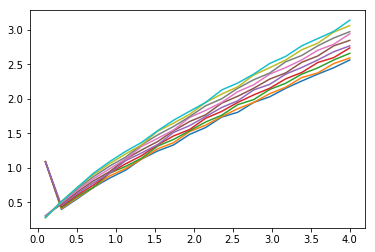

In [106]:
for i in range(Nϵ):
    plt.plot(Kgrid, Kp[:,i])

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

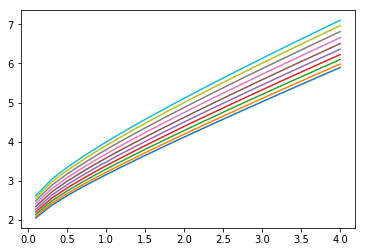

In [101]:
for i in range(Nϵ):
    plt.plot(Kgrid, Vp[:,i])

plt.show

### Question 4: Compute the market-clearing wage

In [243]:
import numpy as np
from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import fsolve
from scipy.optimize import root
from matplotlib import pyplot as plt
import tauchen

Nϵ = 5
sizeK = 10
tol, epsi, maxiter =1e-3,1, 1000

### State space K
Kmin=0.2
Kmax=4
Kgrid=np.linspace(Kmin,Kmax,sizeK)

### State space epsilon, from Tauchen
[A, P] = tauchen.approx_markov(ρ, σ, m=2, n=Nϵ)  #b is the constant in the AR1 and m is the standard deviation span #b is the constant in the AR1 and m is the standard deviation span

iterate = 100000
distribution = np.ones_like(A)/len(A)
for i in range(iterate):
    distribution = np.dot(distribution,P)

# Interpolant to evaluate Value Function
def interpolant(x,Kgrid,Vp):
    t = interpolate.interp1d(Kgrid,Vp,fill_value="extrapolate")
    return t(x)

# Equation 2 in Pbset: Value of staying in the market
def Bellman(kp, *params):
    Kgrid, Vp, j, l, A, P, W, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π = params
        
    exp=np.zeros(Nϵ) # Dimension of exp is dimension of A, number of shocks
    for i in range(Nϵ):
        exp[i] =  P[l,i]*interpolant(kp,Kgrid,Vp[:,i])  
    FutureVal = β * np.sum(exp)  
    
    N         = n_f(A[l], Kgrid[j], W)
    Y         = prod(A[l], Kgrid[j], N)
    R         = r_f(A[l], Kgrid[j], N)
    profit    = Π(Y, kp, Kgrid[j], N, W)
    V         = profit + FutureVal
    
    exitpayoff = (1-δ)*Kgrid[j]
    staypayoff = V - cf
    if exitpayoff > staypayoff:
        exit[j,l] = 1
        return -exitpayoff
    else:
        exit[j,l] = 0
        return -staypayoff
    
    
    
def Bellman_new(kp, Vp, Kgrid, P, l, Nϵ):

    exp=np.zeros(np.int_(Nϵ)) # Dimension of exp is dimension of A, number of shocks

    for i in range(Nϵ):
        exp[i] = β * P[l,i]*interpolant(kp,Kgrid,Vp[:,i])
        
    value = - kp + np.sum(exp)
    return - value
            



#Vp=Kmin*np.ones([sizeK,Nϵ])
#Kp=Krep*np.ones([sizeK,Nϵ])


def get_wage(x,*args):
    Vp, Kp, sizeK, Nϵ, Ce, Krep, A, P, distribution = args
    iter= 0
    Vp=Kmin*np.ones([sizeK,Nϵ])
    Kp=Krep*np.ones([sizeK,Nϵ])
    exit =np.zeros([sizeK,Nϵ])
    Vp_new=np.zeros([sizeK,Nϵ])
    Kp_new=np.zeros([sizeK,Nϵ])
    print("Guess for W is: ", x)
    while iter < maxiter:

        #print("Number of iterations: ", iter)

        for j in range(sizeK):

            for l in range(Nϵ):
    #             print('Random shock number ', l)
                # Make the value function dependent on future K only
                params = Kgrid, Vp, j, l, A, P, x, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π
                solve = minimize(Bellman,Kp[j,l], args = params)
                Kp_new[j,l] = solve.x
                Vp_new[j,l] = - solve.fun
                if exit[j,l] == 1:
                     Kp_new[j,l] = 0
                


        epsi = ((Vp_new - Vp) ** 2).sum()
#         print("Error term: ", epsi)
        if epsi < tol:
            break
        #Update
        Kp=Kp_new*1.
        Vp = Vp_new*1.
        iter=iter+1

    # compute the value function of new entrants
    Vhat = Vp[0,:]
    for l in range(Nϵ):
        Bellman_new_x = lambda x: Bellman_new(x, Vp, Kgrid, P, l, Nϵ)
        solve = minimize(Bellman_new_x, Krep)
        Vhat[l] = - solve.fun

    integral = np.dot(distribution, Vhat)*ν

    clearing = Ce - integral
    print(clearing)

    return clearing




In [244]:
Ce = 0.1
#Vp=Kmin*np.ones([sizeK,Nϵ])
#Kp=Krep*np.ones([sizeK,Nϵ])
Vp=Kmin*np.ones([sizeK,Nϵ])
Kp=Krep*np.ones([sizeK,Nϵ])
params = Vp, Kp, sizeK, Nϵ, Ce, Krep, A, P, distribution
wage = fsolve(get_wage, 0.8, args = params)



Guess for W is:  [0.96]
-1.0556118132254451e+37
Guess for W is:  [0.96]
-1.0556118132254451e+37
Guess for W is:  [0.96]
-1.0556118132254451e+37
Guess for W is:  [0.96000001]
-4.8443920181254077e+36
Guess for W is:  [0.96000003]
-1.0556228093061421e+37


In [247]:
import numpy as np
from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import fsolve
from scipy.optimize import root
from matplotlib import pyplot as plt
import tauchen

Nϵ = 5
sizeK = 10
tol, epsi, maxiter =1e-3,1, 1000

### State space K
Kmin=0.2
Kmax=4
Kgrid=np.linspace(Kmin,Kmax,sizeK)

### State space epsilon, from Tauchen
[A, P] = tauchen.approx_markov(ρ, σ, m=2, n=Nϵ)  #b is the constant in the AR1 and m is the standard deviation span #b is the constant in the AR1 and m is the standard deviation span

iterate = 100000
distribution = np.ones_like(A)/len(A)
for i in range(iterate):
    distribution = np.dot(distribution,P)

# Interpolant to evaluate Value Function
def interpolant(x,Kgrid,Vp):
    t = interpolate.interp1d(Kgrid,Vp,fill_value="extrapolate")
    return t(x)

# Equation 2 in Pbset: Value of staying in the market
def Bellman(kp, *params):
    Kgrid, Vp, j, l, A, P, W, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π = params
        
    exp=np.zeros(Nϵ) # Dimension of exp is dimension of A, number of shocks
    for i in range(Nϵ):
        exp[i] =  P[l,i]*interpolant(kp,Kgrid,Vp[:,i])  
    FutureVal = β * np.sum(exp)  
    
    N         = n_f(A[l], Kgrid[j], W)
    Y         = prod(A[l], Kgrid[j], N)
    R         = r_f(A[l], Kgrid[j], N)
    profit    = Π(Y, kp, Kgrid[j], N, W)
    V         = profit + FutureVal
    
    exitpayoff = (1-δ)*Kgrid[j]
    staypayoff = V - cf
    if exitpayoff > staypayoff:
        exit[j,l] = 1
        return -exitpayoff
    else:
        exit[j,l] = 0
        return -staypayoff
    
    
    
def Bellman_new(kp, Vp, Kgrid, P, l, Nϵ):

    exp=np.zeros(np.int_(Nϵ)) # Dimension of exp is dimension of A, number of shocks

    for i in range(Nϵ):
        exp[i] = β * P[l,i]*interpolant(kp,Kgrid,Vp[:,i])
        
    value = - kp + np.sum(exp)
    return - value
            



#Vp=Kmin*np.ones([sizeK,Nϵ])
#Kp=Krep*np.ones([sizeK,Nϵ])
W = np.linspace(0.8,1,10)
clearing = np.zeros_like(W)
Vp=Kmin*np.ones([sizeK,Nϵ])
Kp=Krep*np.ones([sizeK,Nϵ])

Vp_new=np.zeros([sizeK,Nϵ])
Kp_new=np.zeros([sizeK,Nϵ])

for i,item in enumerate(W):
    print("Guess for W is: ", item)

    iter= 0


    while iter < maxiter:

        #print("Number of iterations: ", iter)

        for j in range(sizeK):

            for l in range(Nϵ):
    #             print('Random shock number ', l)
                # Make the value function dependent on future K only
                params = Kgrid, Vp, j, l, A, P, item, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π
                solve = minimize(Bellman,Kp[j,l], args = params)
                Kp_new[j,l] = solve.x
                Vp_new[j,l] = - solve.fun
                if exit[j,l] == 1:
                     Kp_new[j,l] = 0


        epsi = ((Vp_new - Vp) ** 2).sum()
#         print("Error term: ", epsi)
        if epsi < tol:
            break
        #Update
        Kp=Kp_new*1.
        Vp = Vp_new*1.
        iter=iter+1

    # compute the value function of new entrants
    Vhat = Vp[0,:]
    for l in range(Nϵ):
        Bellman_new_x = lambda x: Bellman_new(x, Vp, Kgrid, P, l, Nϵ)
        solve = minimize(Bellman_new_x, Krep)
        Vhat[l] = - solve.fun

    integral = np.dot(distribution, Vhat)*ν

    clearing[i] = Ce - integral
    print(clearing[i])





Guess for W is:  0.8
-1.2295959428595755
Guess for W is:  0.8222222222222223
-1.1880383779234664
Guess for W is:  0.8444444444444444
-1.041439140213125
Guess for W is:  0.8666666666666667
-0.9117227381546497
Guess for W is:  0.888888888888889
-0.7981688520374743
Guess for W is:  0.9111111111111111
-0.6966231385540205
Guess for W is:  0.9333333333333333
-0.6007055249177455
Guess for W is:  0.9555555555555555
-0.5135581652593224
Guess for W is:  0.9777777777777777
-2.6404680601163125e+36
Guess for W is:  1.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: overflow encountered in square
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:155: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:155: RuntimeWarning: invalid value encountered in less
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:391: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:391: RuntimeWarning: invalid value encountered in less
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:613: RuntimeWarning: overflow encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:155: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
C:\ProgramData\Anaconda3\lib\site-

nan


### Question 5: Solving for the static distribution of firms and the mass of firms

#### Get the value function at the optimal wage


In [248]:
import numpy as np
from scipy.optimize import minimize
from scipy import interpolate
from matplotlib import pyplot as plt
import tauchen

sizeK = 10
tol, epsi, maxiter =1e-6,1, 1000
Nϵ = 5
### State space K
Kmin=0.1
Kmax=4
Kgrid=np.linspace(Kmin,Kmax,sizeK)

### State space epsilon, from Tauchen
[A, P] = tauchen.approx_markov(ρ, σ, m=2, n=Nϵ)  #b is the constant in the AR1 and m is the standard deviation span #b is the constant in the AR1 and m is the standard deviation span

wrep = 0.955

iterate = 100000
distribution = np.ones_like(A)/len(A)
for i in range(iterate):
    distribution = np.dot(distribution,P)


# ##interpolation function that returns function handle given interp type
# def interpolate(k_grid, policy, method="pw-linear", ndegree=None, A=None ):
#     if method == "pw-linear":
#         t = interpol.interp1d(k_grid, policy, kind='linear',fill_value="extrapolate")
            
#     elif method == "chebyshev":
#         ###Get chebyshev coefficients 
#         coeff = chebyshev.chebfit(k_grid, policy, ndegree)
#         t = lambda x: chebyshev.chebval(x, coeff)

#     elif method == "cubic-spline":
#         t = interpol.interp1d(k_grid, policy, kind='cubic',fill_value="extrapolate")
        
#     else: raise NameError("invalid choice of interpolation method. Valid methods are \
#                            'pw-linear,' 'chebyshev,' 'cubic-spline,' or 'ar_1'")
#     return t



# Interpolant to evaluate Value Function
def interpolant(x,Kgrid,Vp):
    t = interpolate.interp1d(Kgrid,Vp,fill_value="extrapolate")
    return t(x)

# Equation 2 in Pbset: Value of staying in the market
def Bellman(x, *params):
    Kgrid, Vp, j, l, A, P, W, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π = params
        
    exp=np.zeros(Nϵ) # Dimension of exp is dimension of A, number of shocks
    for i in range(Nϵ):
        exp[i] =  P[l,i]*interpolant(x,Kgrid,Vp[:,i])  
    FutureVal = β * np.sum(exp)  
    
    N         = n_f(A[l], Kgrid[j], W)
    Y         = prod(A[l], Kgrid[j], N)
    R         = r_f(A[l], Kgrid[j], N)
    profit    = Π(Y, x, Kgrid[j], N, W)
    V         = profit + FutureVal
    
    exitpayoff = (1-δ)*Kgrid[j]
    staypayoff = V - cf
    if exitpayoff > staypayoff:
        exit[j,l] = 1
        return -exitpayoff
    else:
        exit[j,l] = 0
        return -staypayoff


iter= 0
Vp=Kmin*np.ones([sizeK,Nϵ])
Kp=Krep*np.ones([sizeK,Nϵ])
exit =np.zeros([sizeK,Nϵ])
Vp_new=np.zeros([sizeK,Nϵ])
Kp_new=np.zeros([sizeK,Nϵ])

while iter < maxiter:

    print("Number of iterations: ", iter)

    for j in range(sizeK):

        for l in range(Nϵ):
#             print('Random shock number ', l)
            # Make the value function dependent on future K only
            params = Kgrid, Vp, j, l, A, P, wrep, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π
            solve = minimize(Bellman,Kp[j,l], args = params)
            Kp_new[j,l] = solve.x
            Vp_new[j,l] = - solve.fun
            if exit[j,l] == 1:
                 Kp_new[j,l] = 0

    epsi = ((Vp_new - Vp) ** 2).sum()
    print("Error term: ", epsi)
    if epsi < tol:
        break
    #Update
    Kp=Kp_new*1.
    Vp = Vp_new*1.
    iter=iter+1






Number of iterations:  0
Error term:  214.9925
Number of iterations:  1
Error term:  0.03392358233856508
Number of iterations:  2
Error term:  0.08856249412293439
Number of iterations:  3
Error term:  0.055109851462272985
Number of iterations:  4
Error term:  0.23632281380858333
Number of iterations:  5
Error term:  0.05440056534049882
Number of iterations:  6
Error term:  0.4927960720020035
Number of iterations:  7
Error term:  0.05107968234447316
Number of iterations:  8
Error term:  0.021033617791622675
Number of iterations:  9
Error term:  0.774489451306943
Number of iterations:  10
Error term:  0.18379277796691568
Number of iterations:  11
Error term:  0.5388845603214406
Number of iterations:  12
Error term:  0.4391158761176269
Number of iterations:  13
Error term:  0.3738385495889236
Number of iterations:  14
Error term:  0.6661851796219322
Number of iterations:  15
Error term:  0.4543573575743164
Number of iterations:  16
Error term:  0.7332425536514068
Number of iterations:  17

Error term:  1.3161569189288055e-06
Number of iterations:  136
Error term:  1.212970218665408e-06
Number of iterations:  137
Error term:  1.1178733552858733e-06
Number of iterations:  138
Error term:  1.0302320856698096e-06
Number of iterations:  139
Error term:  9.49461891322093e-07


<function matplotlib.pyplot.show(*args, **kw)>

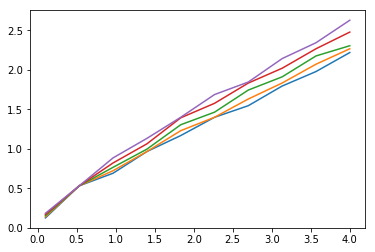

In [249]:
for i in range(Nϵ):
    plt.plot(Kgrid, Kp[:,i])

plt.show

In [255]:
Stay = exit*(-1) + 1
Stay = Stay.flatten()
print(Stay)
test = np.tile(Kgrid, Nϵ)
print(test)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[0.1        0.53333333 0.96666667 1.4        1.83333333 2.26666667
 2.7        3.13333333 3.56666667 4.         0.1        0.53333333
 0.96666667 1.4        1.83333333 2.26666667 2.7        3.13333333
 3.56666667 4.         0.1        0.53333333 0.96666667 1.4
 1.83333333 2.26666667 2.7        3.13333333 3.56666667 4.
 0.1        0.53333333 0.96666667 1.4        1.83333333 2.26666667
 2.7        3.13333333 3.56666667 4.         0.1        0.53333333
 0.96666667 1.4        1.83333333 2.26666667 2.7        3.13333333
 3.56666667 4.        ]


In [ ]:
# Guess for the distribution of firms across capital and productivity states
Stay = exit*(-1) + 1
Stay = Stay.transpose()

#stack Kgrid Nϵ times 
Kgrid = np.tile(Kgrid, Nϵ)

#Flatten Kprime
Kp = Kp.flatten()

#Expand the transition matrix for the markov process
Πϵ = np.tile(P,sizeK)



G = np.ones(Nϵ*sizeK)/(Nϵ*sizeK)




# Simulate over the policy function for K 
